# Usage

Import the library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tefs
%config InlineBackend.figure_format = 'retina'
plt.rc("text", usetex=True)


Generate some random data

In [2]:
np.random.seed(0)
n = 1000
x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)
x3 = np.random.normal(size=n)
x4 = x1 + x2 + x3 + np.random.normal(size=n)
y = x1 + x2 + x3 + np.random.normal(size=n)
data = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'y': y})

data.head()

,x1,x2,x3,x4,y
0,1.764052,0.555963,-1.532921,2.380368,1.400443
1,0.400157,0.892474,-1.711970,0.149383,1.424361
2,0.978738,-0.422315,0.046135,0.488071,0.873649
3,2.240893,0.104714,-0.958374,1.638863,2.523680
4,1.867558,0.228053,-0.080812,0.803944,0.276468


Define features and target

In [3]:
features = data[['x1', 'x2', 'x3']]
target = data['y']
features_names = list(features.columns)

Set the hyperparameters

In [4]:
n_samples = len(data)
k = n_samples // 10 # Set k using the rule of thumb
direction = 'forward' # or 'backward'
lag_features = [1]
lag_target = [1]

Perform feature selection

In [5]:
results = tefs.fs(
    features=features.values,
    target=target.values,
    k=k,
    lag_features=lag_features,
    lag_target=lag_target,
    direction=direction,
    verbose=1,
    var_names=features_names, # optional
    n_jobs=4,
)

Adding feature: x2 with TE score: -0.002435012237684899
Adding feature: x1 with TE score: -0.0015847873844891665
Adding feature: x3 with TE score: -0.001428146893958049


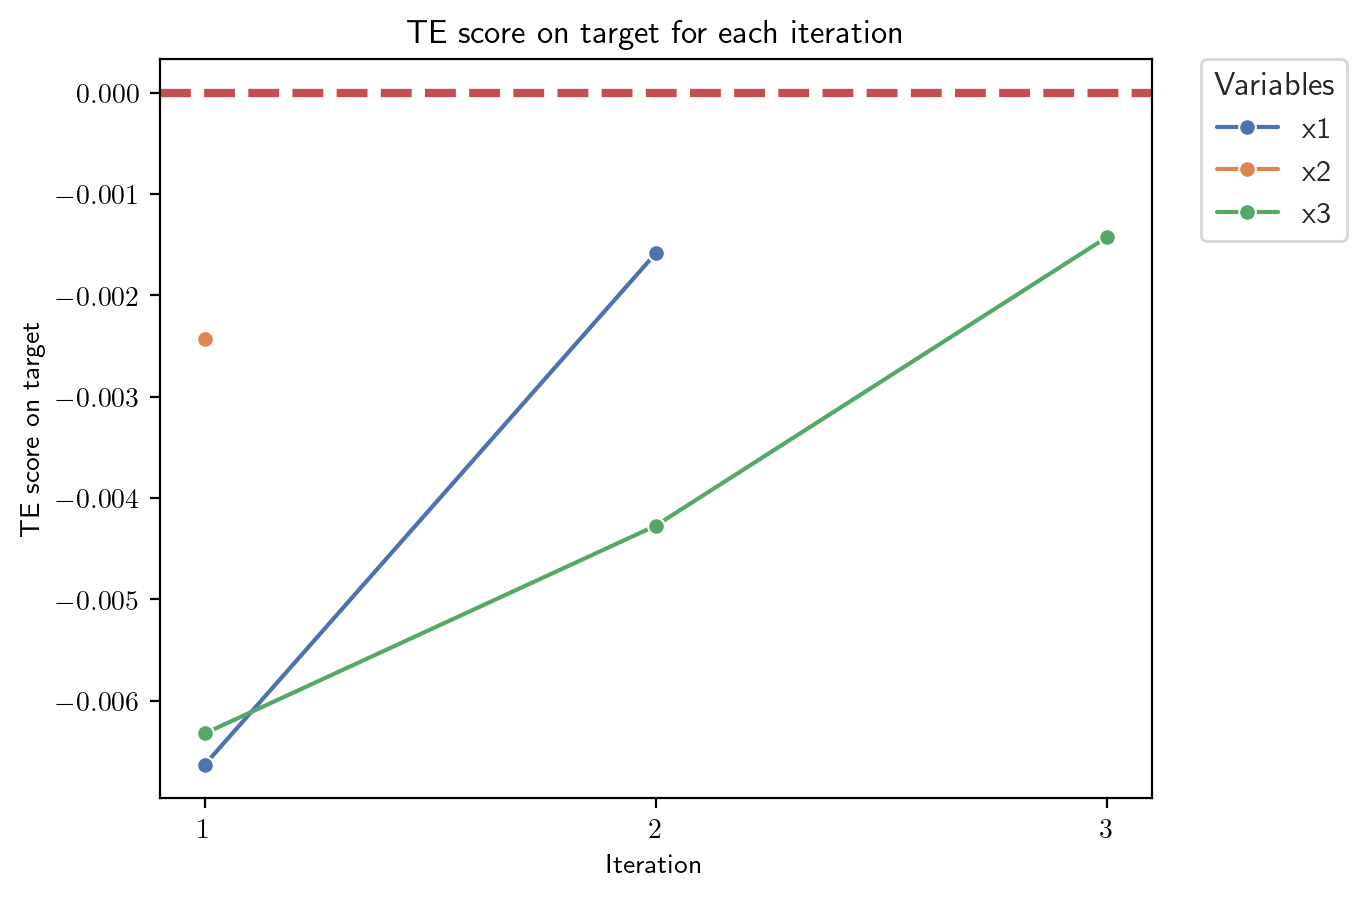

In [6]:
fig, ax = plt.subplots()
tefs.plot_te_results(results, features_names, ax)

Select features based on threshold

In [7]:
features_indexes = tefs.select_features(
    results=results,
    threshold=0,
    direction=direction,
    verbose=1,
    )

Selecting features with direction forward and threshold 0
Stopping condition reached: all feature scores are negative


In [8]:
selected_features = [features_names[i] for i in features_indexes]
selected_features

[]

Select specific number of features

In [9]:
features_indexes = tefs.select_n_features(
    results=results,
    n=2,
    direction=direction,
    verbose=1,
    )

Selecting 2 features with direction forward


In [10]:
selected_features = [features_names[i] for i in features_indexes]
selected_features

['x1', 'x2']